## learning-AI101 : glass regression
### 유리 데이터를 KNR, multiple regression, ridge, lasso로 regression

<br>

- **임규연 (lky473736)**
- 2024.07.29.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/42/glass+identification
- **kaggle** : https://www.kaggle.com/datasets/uciml/glass
- **data abstract** : Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis.  BEAGLE is a product available through VRS Consulting, Inc.; 4676 Admiralty Way, Suite 206; Marina Del Ray, CA 90292 (213) 827-7890 and FAX: -3189. In determining whether the glass was a type of "float" glass or not. The study of classification of types of glass was motivated by criminological investigation.  At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!
- **memo** : <혼자 공부하는 머신러닝&딥러닝> 1회독을 하였고, 본 문서를 작성하면서 전체적으로 책에 있는 내용을 다시 따라하고 복습하려고 한다. 따라서 스스로 내 자신을 가르친다고 생각하고 설명을 길게 작성하면서 regression을 진행한다.

------

- **CAUTION : `./classification_glass.ipynb`에서 본 데이터로 이미 EDA를 진행하였기 때문에 regression을 할 이 파일에서는 EDA를 생략한다. 바로 아래에 파일을 연 후 전처리 단계부터 진행할 예정이다.**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

----

### 1. 파일 열기 및 데이터 준비, 전처리

아래를 고려하여 본 과정을 진행한다.

- 본 regression에서는 feature 중 Mg가 target이 되며, 나머지 특성들 중 몇개를 selection하여 feature을 이룬다. 
- EDA 과정에서 Mg와 상관계수의 절댓값이 높았던 feature만 feature selection을 통하여 데이터를 추린 후 regression을 진행할 예정이다. 이는 아래와 같다.
    - Al과도 상당히 높은 음의 상관관계(-0.48)를 가지고 있음
    - Ba와도 높은 음의 상관관계(-0.49)를 가지고 있음
    - Ca와도 상당한 음의 상관관계(-0.44)를 가지고 있음
    
따라서, **Al, Ba, Ca attributes를 feature로, Mg를 label(target)으로 삼아 regression을 진행한다.** 예상컨대, feature의 수가 너무 적어 train score와 test score의 차이가 좀 날 것이며, 결국엔 overfitting될 가능성이 높아 보인다. 이때는 PolynormialFeatures 메소드를 이용하여 feature의 수를 증가할 예정이다.


In [3]:
# 파일 열기
# header가 없으니 아래의 리스트를 header로 새롭게 지칭

header = ['id', 'RI', 'Na', 'Mg', 
          'Al', 'Si', 'K', 'Ca', 
          'Ba', 'Fe', 'target']
df = pd.read_csv('./data/glass/glass.csv', names=header)
df.head()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
# df의 info 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  target  214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [5]:
# feature, input split 

glass_input = df[['Al', 'Ba', 'Ca']].to_numpy()
glass_target = df['Mg'].to_numpy()

glass_input.shape, glass_target.shape

((214, 3), (214,))

In [6]:
# X_train, y_train, X_test, y_test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(glass_input, 
                                                   glass_target,
                                                   test_size=0.2)

In [32]:
# StandardScaler을 통한 정규화 진행

from sklearn.preprocessing import StandardScaler
ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)

추가적으로 train score가 저조한 상황 및 train score와 test score의 극심한 차이가 나는 상황을 대비하여, feature의 수를 늘린 X_train_poly_scaled까지 준비한다.

In [14]:
# PolynormialFeatures로 feature 늘리기

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3) # 3차까지
poly.fit(X_train)

X_train_poly = poly.transform (X_train)
X_test_poly = poly.transform (X_test)

print (f"shape | X_train_poly : {X_train_poly.shape}, X_test_poly : {X_test_poly.shape}")
print (f"poly | {poly.get_feature_names_out()}")

ss_transformer = StandardScaler()
ss_transformer.fit(X_train_poly)

X_train_poly_scaled = ss_transformer.transform(X_train_poly)
X_test_poly_scaled = ss_transformer.transform(X_test_poly)

shape | X_train_poly : (171, 20), X_test_poly : (43, 20)
poly | ['1' 'x0' 'x1' 'x2' 'x0^2' 'x0 x1' 'x0 x2' 'x1^2' 'x1 x2' 'x2^2' 'x0^3'
 'x0^2 x1' 'x0^2 x2' 'x0 x1^2' 'x0 x1 x2' 'x0 x2^2' 'x1^3' 'x1^2 x2'
 'x1 x2^2' 'x2^3']


-------

### 2. 각종 모델을 적용하여 regression
- KNR, multiple regression, ridge, lasso을 이용한 regression
- 순서는 아래와 같이 진행
    - **적합한 회귀 모델 foundation을 위한 모델 별 simulation**
    - **(1) KNR**
        - (1-1) X_train_poly_scaled, X_test_poly_scaled로 진행
        - (1-2) 시각화
    - **(2) multiple regression**
        - (2-1) X_train_poly_scaled, X_test_poly_scaled로 진행
        - (2-2) 시각화
    - **(3) regularization**
        - (3-1) ridge, random search로 최적의 alpha값 찾기
        - (3-2) lasso, grid search로 최적의 alpha값 찾기
            - (3-2 분석) 0.01 점수가 최선일까?
    - **4개의 모델을 시각화 자료로 비교**
        - 각 모델의 MSE, MAE, R^2, RMSE를 barplot으로 시각화

#### 적합한 회귀 모델 foundation을 위한 모델 별 simulation
- Linear Regression, Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor을 적용하여 score가 어떻게 나오는 지를 확인
- 각 모델의 hyperparameter은 재량껏 정함

In [17]:
# 모델 별 simulation

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

models = {
    "KNR" : KNeighborsRegressor(n_neighbors=10),
    "linear regression" : LinearRegression(),
    "ridge" : Ridge(alpha=1.0),
    "lasso" : Lasso(alpha=1.0),
    "random forest" : RandomForestRegressor(n_estimators=100, random_state=42),
    "gradient boosting" : GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# X_train_poly_scaled, X_test_poly_scaled을 사용
for name, model in models.items() :
    model.fit(X_train_poly_scaled, y_train)
    train_score = model.score(X_train_poly_scaled, y_train)
    test_score = model.score(X_test_poly_scaled, y_test)
    print(f"{name} - Train score: {train_score:.4f}, Test score: {test_score:.4f}")

KNR - Train score: 0.8111, Test score: 0.7874
linear regression - Train score: 0.8709, Test score: 0.8468
ridge - Train score: 0.7783, Test score: 0.7762
lasso - Train score: 0.0196, Test score: 0.0153
random forest - Train score: 0.9702, Test score: 0.8179
gradient boosting - Train score: 0.9928, Test score: 0.7908


**전체적으로 train score가 매우 괜찮다만, lasso에서의 train score는 매우 나쁘다. 0.01이라는, 다른 의미에서 기적적인 수치를 보여주고 있다는 것.** 따라서 추후에 lasso를 model로 하여 regression을 진행할 시에 이를 분석해보도록 하자.

#### 2-1) KNR (K-nearest neighbors regression)

<img src='https://miro.medium.com/v2/resize:fit:1400/0*ksMa1Of3NFCvHo_Y' width='500px'>

- KNN이랑 거의 비슷하다. KNN이랑 다른 점이 있다면, **예측값은 인접한 K개의 data의 평균**이라는 점이다.
- 순서는 아래와 같다.
    - (1) 예측하고자 하는 instacnce와 나머지 모든 instance의 euclidean distance를 전부 재본다
    - (2) distance를 정렬하였을 때, 가장 가까운 거리 순으로 K개의 data를 확인한다
    - (3) data의 평균이 예측값이다. 
- 훈련 세트를 저장하는 것이 훈련의 전부 (사례 기반 학습 알고리즘)
- hyperparameter인 n_neighbors의 조정으로 tuning 가능
- 장점 
    - 가장 단순한 알고리즘
    - records가 적은 data일 때 유리
- 단점 
    - records가 많은 data라면 각각의 distance를 구하는데 시간이 오래 걸림
    - 원리가 매우 단순하여 underfitting될 가능성 있음
    - 각 feature의 scale이 다를 시 scaling이 필요
    
최적의 n_neighbors를 찾기 위해 for문을 이용한 brute force를 진행한다. 범위는 아래와 같다.
- n_neighbors : 3~130의 int range

In [19]:
# KNR 활용한 모델 fit 및 train score, test score 출력
# 이때, n_neighbors 하이퍼파라미터를 조정해나가면서, 점수를 get

score_list = [] # [n_neighbors, [train score, test score]] <-- R^2 결정계수

# n_neighbors를 3부터 130까지 진행

for num in range (3, 131) :
    knr = KNeighborsRegressor(n_neighbors=num)
    knr.fit(X_train_poly_scaled, y_train)
    
    current_score = [num, [knr.score(X_train_poly_scaled, y_train),
                             knr.score(X_test_poly_scaled, y_test)]]
    score_list.append (current_score)
    
    print (f'n_neighbors : {num} | train score : {current_score[1][0]}, test score : {current_score[1][1]}')

n_neighbors : 3 | train score : 0.901130559417695, test score : 0.7039470889760006
n_neighbors : 4 | train score : 0.8759725772717906, test score : 0.7582486418368758
n_neighbors : 5 | train score : 0.8532811110336739, test score : 0.809504973042008
n_neighbors : 6 | train score : 0.8417122981693159, test score : 0.7878769553898595
n_neighbors : 7 | train score : 0.8293677533612351, test score : 0.7758244343949784
n_neighbors : 8 | train score : 0.8211121598028784, test score : 0.8147367310368412
n_neighbors : 9 | train score : 0.8129944967177614, test score : 0.8071157217538851
n_neighbors : 10 | train score : 0.8110874634573099, test score : 0.7874322165731894
n_neighbors : 11 | train score : 0.8044830395704378, test score : 0.7861895412126058
n_neighbors : 12 | train score : 0.7979257166032605, test score : 0.7762535253788685
n_neighbors : 13 | train score : 0.792246715061014, test score : 0.7685752858772346
n_neighbors : 14 | train score : 0.7838809375255378, test score : 0.7734132

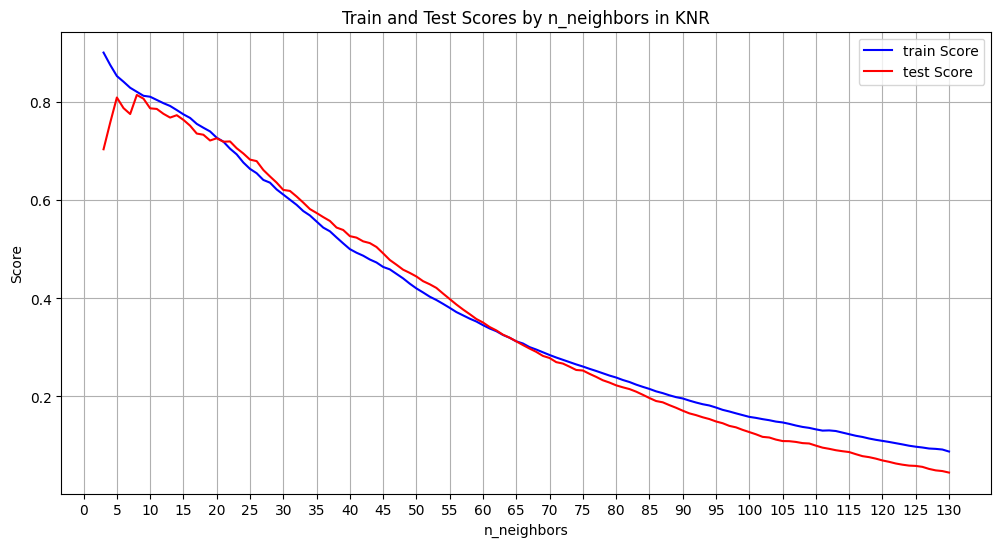

In [25]:
# 위 결과를 시각화화여 가장 적합한 n_neighbors 파라미터를 찾는다

n_neighbors_values = [score[0] for score in score_list] # n_neighbors
train_scores = [score[1][0] for score in score_list] # train score
test_scores = [score[1][1] for score in score_list] # test score

plt.figure(figsize=(12, 6))
plt.plot(n_neighbors_values, train_scores, label='train Score', color='blue')
plt.plot(n_neighbors_values, test_scores, label='test Score', color='red')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('Train and Test Scores by n_neighbors in KNR')
plt.legend()
plt.xticks(range(0, 131, 5))
plt.grid(True)
plt.show()

위 figure을 보고 아래와 같이 분석 가능하다.

- (1) **진짜 재미있는 건 둘 다 굉장히 비슷한 경향성을 띄면서, 모양까지 비슷하게 우하향하고 있다는 것이다.**
- (2) 중간에 test score가 train score보다 높은 구간에 존재하는데, 그에 대한 원인을 간단히 추려보면 아래와 같다.
    - test set이 train set보다 모델에 대한 학습정도가 높게 나타나는 분포를 띄고 있을 수도 있다. (매우 희박)
    - 위가 아니라면, overfitting된 것이다.
- (3) 현재 x축에 5~10 구간 중 후반에서 train score가 test score보다 살짝 높으면서도, 둘의 차이가 얼마 나지 않는 저 점이 최적의 n_neighbors일 것이다.

In [30]:
# n_neighbors=8으로 fit, score

knr = KNeighborsRegressor(n_neighbors=8)
knr.fit (X_train_poly_scaled, y_train)

score = [knr.score(X_train_poly_scaled, y_train), knr.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {score}")

train score, test score : [0.8211121598028784, 0.8147367310368412]


In [38]:
# 평가를 위한 MSE, MAE, R^2, RMSE 진행

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = y_test
y_pred = knr.predict(X_test_poly_scaled)

# MSE
mse = mean_squared_error(y_true, y_pred)
print(f'MSE : {mse}')

# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE : {mae}')

# R^2
r2 = r2_score(y_true, y_pred)
print(f'R^2 : {r2}')

# RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'RMSE : {rmse}')

knr_score = [mse, mae, r2, rmse]

MSE : 0.39000737645348843
MAE : 0.34404069767441864
R^2 : 0.8147367310368412
RMSE : 0.6245057057013078


#### 2-2) multiple regression

<img src='https://user-images.githubusercontent.com/31824102/35181413-0ee0c08c-fdb9-11e7-9ef1-50d888cba8e1.PNG
' width='500px'>
- feature의 수가 1개를 linear regression, feature의 수가 2개 이상을 multiple regression이라고 함.
- **feature 수가 늘어났으니, linear combination formula의 항은 하나 더 늘어난 셈**
- 기존의 linear regression은 perceptron 하나가 weighted sum을 이루었다면, 이제는 perceptron 2개 이상이 weighted sum을 이룬다고 생각할 것.
- feature 수가 증가한다면, 차원이 증가하여 학습을 제대로 하지 못하는 상황이 일어날 수 있음.
    - feature 수가 증가한다면 고려해야 할 plane, 즉 추세의 차원이 늘어날 수 있어 복잡도가 증가한다
    - 복잡도가 증가함에 따라서 curse of dimensionality가 발생할 수 있음 -> feature selection나 L2, L1 규제와 같은 같은 해결책 존재

In [35]:
# linear regression 메소드 그대로 multiple regression 진행

lr = LinearRegression()
lr.fit (X_train_poly_scaled, y_train)

score = [lr.score(X_train_poly_scaled, y_train), lr.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {score}")

train score, test score : [0.8708634597747511, 0.8468026921694499]


In [39]:
# 평가를 위한 MSE, MAE, R^2, RMSE 진행

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = y_test
y_pred = lr.predict(X_test_poly_scaled)

# MSE
mse = mean_squared_error(y_true, y_pred)
print(f'MSE : {mse}')

# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE : {mae}')

# R^2
r2 = r2_score(y_true, y_pred)
print(f'R^2 : {r2}')

# RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'RMSE : {rmse}')

lr_score = [mse, mae, r2, rmse]

MSE : 0.322503648138756
MAE : 0.3911188968508518
R^2 : 0.8468026921694499
RMSE : 0.5678940465780179


#### 2-3) regularization

<img src='https://images.datacamp.com/image/upload/v1648205672/image18_a3zz7y.png
' width='500px'>
- 일전에 multiple regression에서의 차원의 저주를 방지하고자 regularization (규제) 등장
- 규제
    - ridge : L2 규제, 제곱항의 sumation, 0이 되는 항 없음
    - lasso : L1 규제, 절댓값항의 sumation, 0이 되는 항 있음 -> feature selection이 가능
    
ridge는 random search, lasso는 grid search를 이용하여 최적의 alpha를 찾을 것이다. 각각을 시각화하여 최상의 score를 파악한다.

##### 2-3-1) ridge

In [54]:
# ridge 모델 fit 및 train score, test score 출력
# 이때, 최적의 alpha를 찾기 위해 random search 기법 사용

from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

ridge = Ridge()

param_grid = {'alpha': uniform(0, 5)}

rs = RandomizedSearchCV(ridge, param_grid, n_iter=100, n_jobs=-1)
rs.fit(X_train_poly_scaled, y_train)

print(f'최적의 hyperparameter : {rs.best_params_}')
print(f'cross-validation score : {rs.best_score_}')

최적의 hyperparameter : {'alpha': 0.2746116138757576}
cross-validation score : 0.35903533494334383


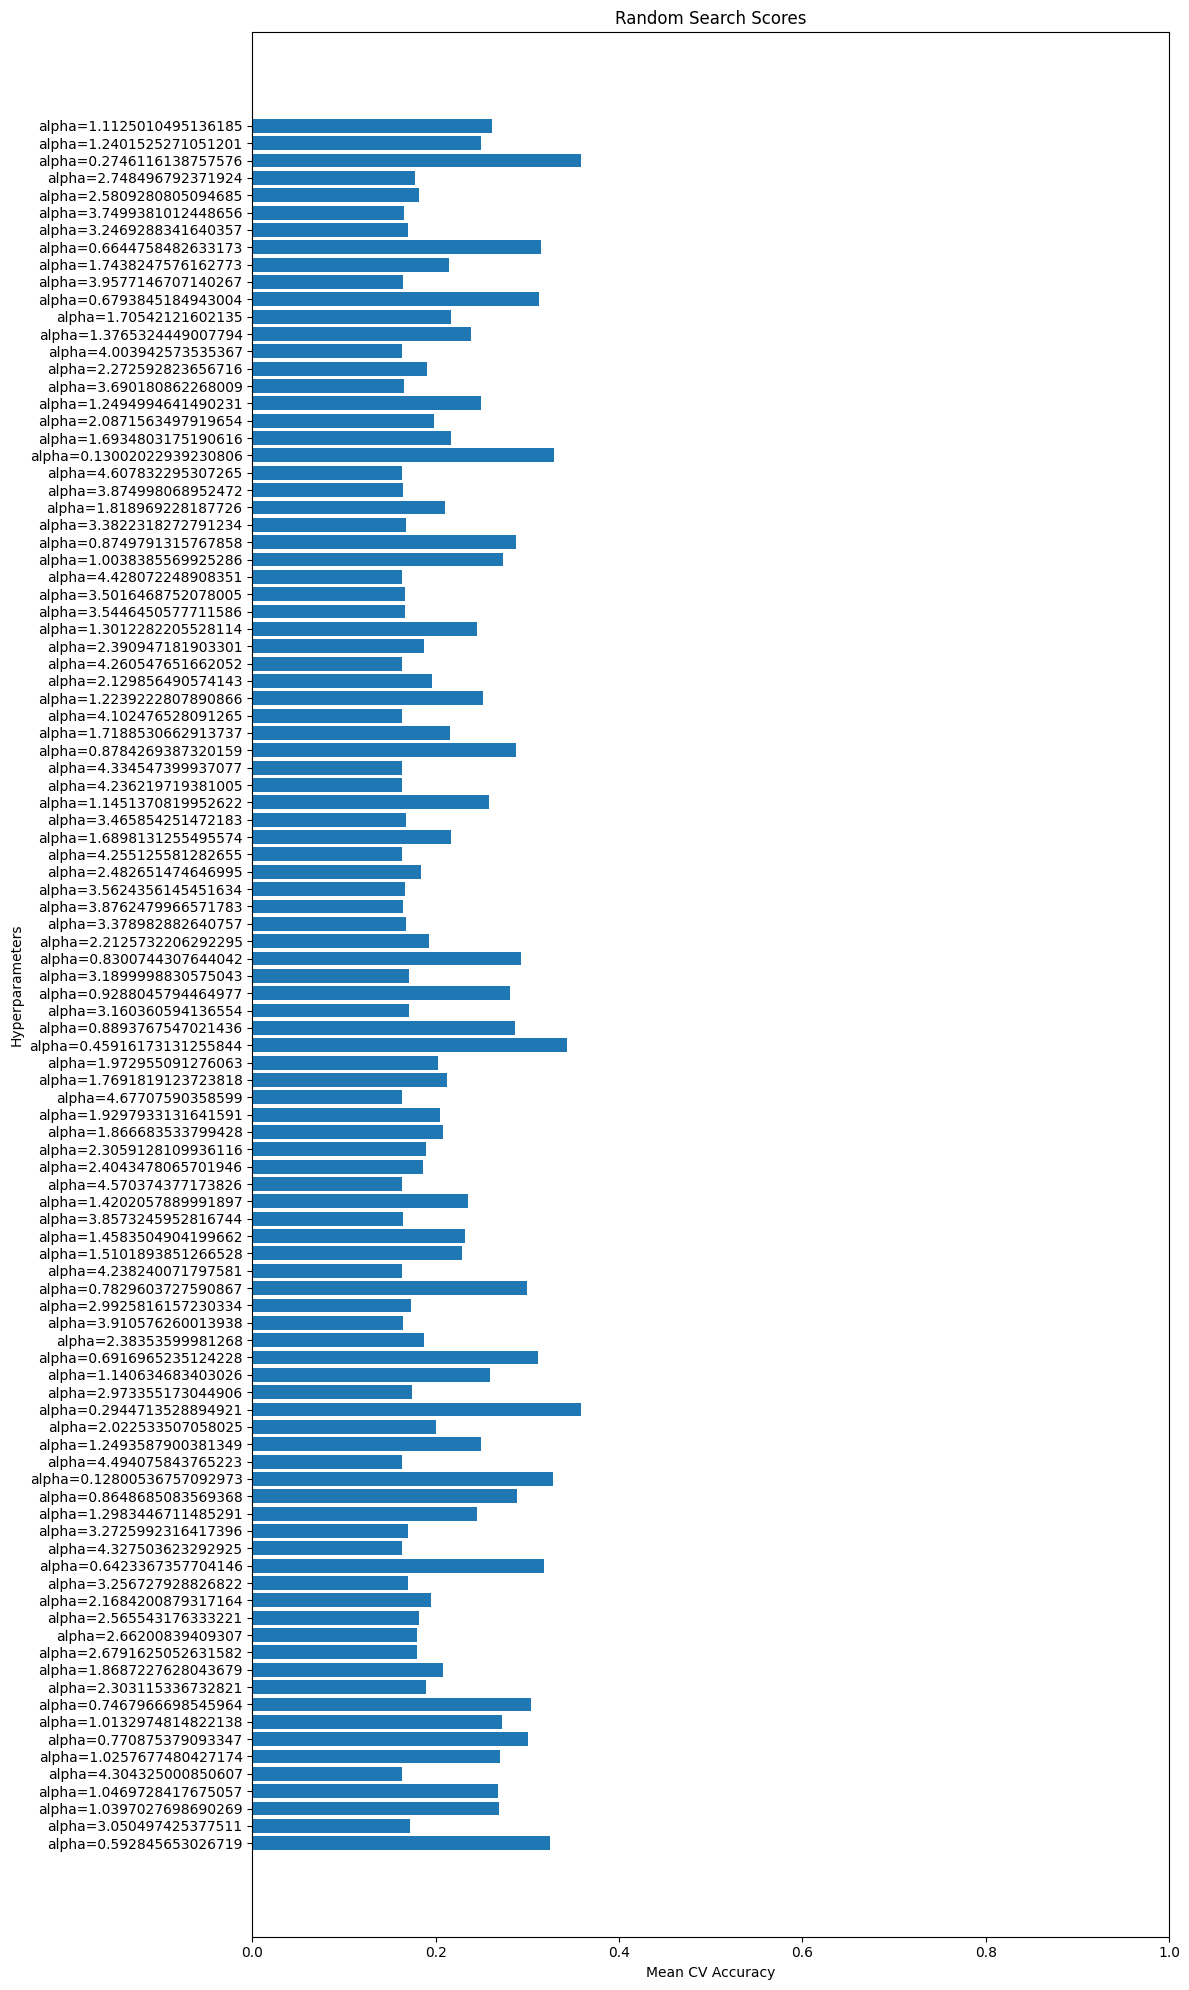

In [55]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
alpha_values = [params[i]['alpha'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"alpha={alpha}" for alpha in alpha_values])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Random Search Scores')
plt.xlim([0, 1.0])  # x 축 범위 설정 (필요에 따라 조정 가능)
plt.tight_layout()
plt.show()

In [68]:
ridge = rs.best_estimator_
# lr.fit (X_train_poly_scaled, y_train)

score = [ridge.score(X_train_poly_scaled, y_train), ridge.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {score}")

train score, test score : [0.7864959469067343, 0.763497091660907]


In [69]:
# 평가를 위한 MSE, MAE, R^2, RMSE 진행

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = y_test
y_pred = ridge.predict(X_test_poly_scaled)

# MSE
mse = mean_squared_error(y_true, y_pred)
print(f'MSE : {mse}')

# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE : {mae}')

# R^2
r2 = r2_score(y_true, y_pred)
print(f'R^2 : {r2}')

# RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'RMSE : {rmse}')

ridge_score = [mse, mae, r2, rmse]

MSE : 0.49787461551966794
MAE : 0.47208518520562487
R^2 : 0.763497091660907
RMSE : 0.7056023069120934


##### 2-3-2) lasso

In [70]:
# lasso 모델 fit 및 train score, test score 출력
# 이때, 최적의 alpha를 찾기 위해 grid search 기법 사용

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso()

param_grid = {'alpha': [i * j for i in range (10) for j in [1, 0.1, 0.01, 0.001]]}

gs = GridSearchCV(ridge, param_grid, cv=10, n_jobs=-1)
gs.fit(X_train_poly_scaled, y_train)

print(f'최적의 hyperparameter : {gs.best_params_}')
print(f'cross-validation score : {gs.best_score_}')

최적의 hyperparameter : {'alpha': 0.2}
cross-validation score : 0.36859282608507427


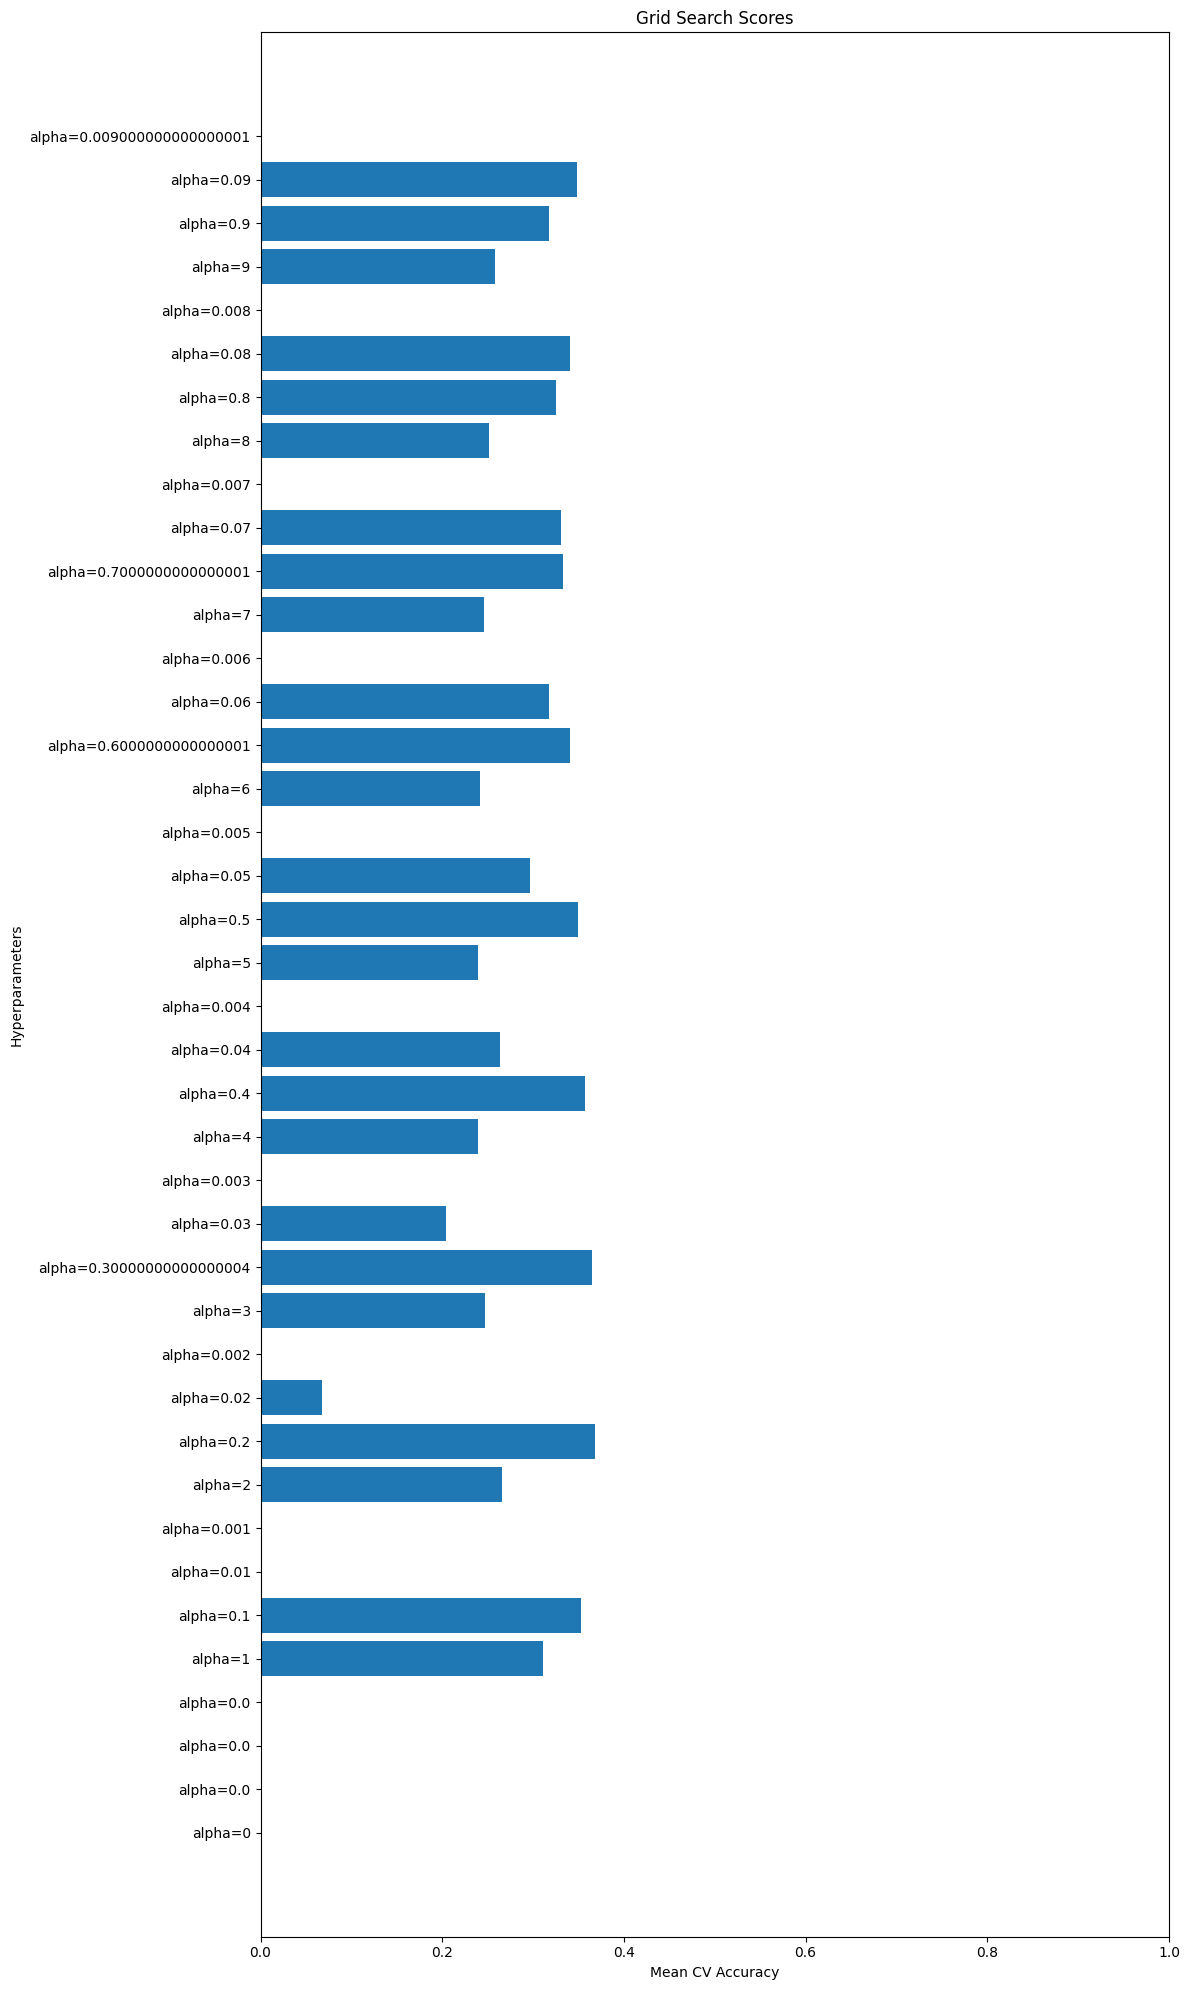

In [71]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = gs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
alpha_values = [params[i]['alpha'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"alpha={alpha}" for alpha in alpha_values])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Grid Search Scores')
plt.xlim([0, 1.0])  # x 축 범위 설정 (필요에 따라 조정 가능)
plt.tight_layout()
plt.show()

In [72]:
lasso = gs.best_estimator_

score = [lasso.score(X_train_poly_scaled, y_train), lasso.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {lasso_score}")

train score, test score : [0.7886903751077187, 0.7650595302862816]


**아까와는 다르게, 정상적인 score가 등장하였다.** 따라서 아까는 단지 hyperparameter의 임의적 설정이 score에 잘못된 영향을 미쳤다고 판단할 수 있겠다.

In [73]:
# 평가를 위한 MSE, MAE, R^2, RMSE 진행

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = y_test
y_pred = ridge.predict(X_test_poly_scaled)

# MSE
mse = mean_squared_error(y_true, y_pred)
print(f'MSE : {mse}')

# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE : {mae}')

# R^2
r2 = r2_score(y_true, y_pred)
print(f'R^2 : {r2}')

# RMSE
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f'RMSE : {rmse}')

lasso_score = [mse, mae, r2, rmse]

MSE : 0.49787461551966794
MAE : 0.47208518520562487
R^2 : 0.763497091660907
RMSE : 0.7056023069120934


#### 2-4) 4개의 모델을 시각화 자료로 비교 : MSE, MAE, R^2, RMSE

- https://jysden.medium.com/%EC%96%B8%EC%A0%9C-mse-mae-rmse%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%98%EB%8A%94%EA%B0%80-c473bd831c62
- **평균 제곱 오차 (Mean Squared Error, MSE)**
  - MSE는 예측 값과 실제 값 사이의 제곱 오차의 평균
  - $\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
  - 값이 작을수록 모델의 예측이 실제 값에 가깝다는 것을 의미

- **평균 절대 오차 (Mean Absolute Error, MAE)**
  - MAE는 예측 값과 실제 값 사이의 절대 오차의 평균
  - $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
  - 직관적이며, 이상치의 영향을 덜 받음
  - 오차이기 때문에, 값이 작을 수록 더 긍정적인 영향 끼침

- **R-제곱 (R-squared, R^2)**
  - \( R^2 \)은 예측 값이 실제 값을 얼마나 잘 설명하는지 나타냄
  - $
    R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
    $
  - 값이 1에 가까울수록 모델의 예측이 실제 값에 가깝다는 것을 의미

- **평균 제곱근 오차 (Root Mean Squared Error, RMSE)**
  - RMSE는 MSE의 제곱근으로, 단위가 원래 데이터와 동일하여 해석하기 쉬움
  - 
    $
    \text{RMSE} = \sqrt{\text{MSE}}
   $


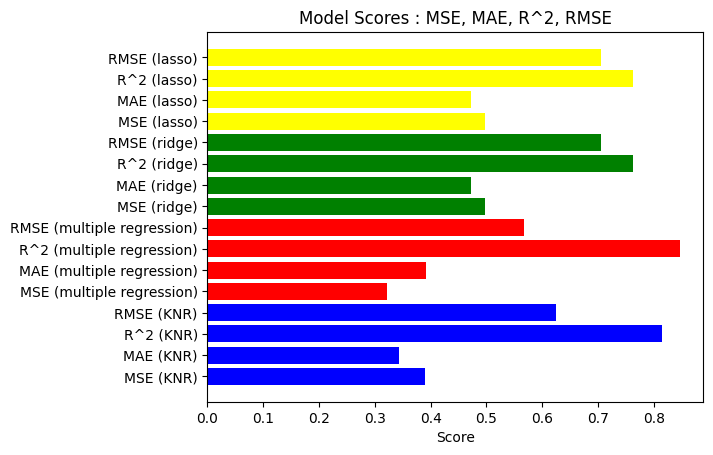

In [75]:
# 각 모델에서의 MSE, MAE, R^2, RMSE를 bar plot으로 나타내고 비교하기

labels = [
    'MSE (KNR)',
    'MAE (KNR)',
    'R^2 (KNR)',
    'RMSE (KNR)',
    'MSE (multiple regression)',
    'MAE (multiple regression)',
    'R^2 (multiple regression)',
    'RMSE (multiple regression)',
    'MSE (ridge)',
    'MAE (ridge)',
    'R^2 (ridge)',
    'RMSE (ridge)',
    'MSE (lasso)',
    'MAE (lasso)',
    'R^2 (lasso)',
    'RMSE (lasso)',
]

scores = []

for score in [knr_score, lr_score, ridge_score, lasso_score] :
    for i in range (4) :
        scores.append (score[i])

plt.barh(labels, scores, color=[co for co in ['blue', 'red', 'green', 'yellow'] for i in range (4)])

plt.xlabel('Score')
plt.title('Model Scores : MSE, MAE, R^2, RMSE')

plt.show()

위 figure를 보고 분석한 결과는 아래와 같다.

- **Lasso 회귀 (노란색)**
  - **RMSE** : 비교적 높은 값으로, 모델의 예측이 실제 값과 큰 차이를 보임
  - **R^2** : 중간 정도의 값으로, 모델이 데이터를 설명하는 데 있어 어느 정도의 설명력을 가짐
  - **MAE** : 중간 값으로, 예측 오차가 크지 않음
  - **MSE** : 비교적 높은 값으로, 큰 오차들이 모델의 성능에 부정적인 영향을 미침

- **Ridge 회귀 (초록색)**
  - **RMSE** : 낮은 값으로, 모델의 예측이 실제 값과 가깝다는 것을 의미
  - **R^2** : 높은 값으로, 모델이 데이터를 매우 잘 설명함
  - **MAE** : 낮은 값으로, 예측 오차가 적음
  - **MSE** : 낮은 값으로, 모델의 예측이 매우 정확함

- **다중 회귀 (Multiple Regression, 빨간색)**
  - **RMSE** : 매우 낮은 값으로, 모델의 예측이 실제 값과 매우 가깝다는 것을 의미
  - **R^2** : 매우 높은 값으로, 모델이 데이터를 거의 완벽하게 설명함
  - **MAE** : 낮은 값으로, 예측 오차가 매우 적음
  - **MSE** : 낮은 값으로, 모델의 예측이 매우 정확함

- **K-최근접 이웃 회귀 (KNR, 파란색)**
  - **RMSE** : 비교적 높은 값으로, 모델의 예측이 실제 값과 큰 차이를 보임
  - **R^2** : 낮은 값으로, 모델이 데이터를 잘 설명하지 못함
  - **MAE** : 비교적 높은 값으로, 예측 오차가 큼
  - **MSE** : 비교적 높은 값으로, 큰 오차들이 모델의 성능에 부정적인 영향을 미침
